In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2626918575772539376
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82767642624
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 14385069805594712547
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-09-17 14:22:24.715994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 14:22:25.732673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0
2023-09-17 14:22:25.740627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


True

In [2]:
import tensorflow.keras.backend as K
def dice_coefficient(y_true, y_pred, axis=(0, 1, 2, 3)):
    """
    Compute mean dice coefficient over all classes.

    Args:
        y_true: Ground truth values for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim, num_classes)
        y_pred: Predictions for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim, num_classes)
        axis (tuple): Spatial axes to sum over when computing numerator and
                      denominator in formula for dice coefficient.
    Returns:
        dice_coefficient (float): Mean value of dice coefficient over all classes.
    """
    dice_numerator = 2 * K.sum(y_pred * y_true, axis=axis) + K.epsilon()
    dice_denominator = K.sum(y_pred ** 2, axis=axis) + K.sum(y_true ** 2, axis=axis) + K.epsilon()

    dice_coefficient = K.mean(dice_numerator / dice_denominator)

    return dice_coefficient

def dice_loss(y_true, y_pred, axis=(0, 1, 2, 3)):
    """
    Compute mean dice loss over all classes.

    Args:
        y_true: Ground truth values for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim, num_classes)
        y_pred: Predictions for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim, num_classes)
        axis (tuple): Spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
    Returns:
        dice_loss (float): Mean value of dice loss over all classes.
    """
    dice_loss = 1 - dice_coefficient(
        y_true=y_true,
        y_pred=y_pred,
        axis=axis
    )

    return dice_loss
def dice_coefficient_binary(y_true, y_pred):
    """
    Compute dice coefficient (binary segmentation).

    Args:
        y_true: Ground truth values for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim)
        y_pred: Predictions for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim)

    Returns:
        dice_coefficient (float): Value of dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + K.epsilon()) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_loss_binary(y_true, y_pred):
    """
    Compute dice loss (binary segmentation).

    Args:
        y_true: Ground truth values for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim)
        y_pred: Predictions for all classes.
                 shape: (batch_size, x_dim, y_dim, z_dim)

    Returns:
        dice_loss (float): Value of dice loss.
    """
    loss = 1 - dice_coefficient_binary(y_true, y_pred)

    return loss


In [3]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage
import albumentations as A

In [4]:
train_data_dir = "/home/rabeea/brain/train/"
val_data_dir = "/home/rabeea/brain/val/"
test_data_dir = "/home/rabeea/brain/test/"

In [5]:
train_mri_paths = [os.path.join(os.path.join(train_data_dir, "images"), x) for x in os.listdir(os.path.join(train_data_dir,"images"))]
train_mask_paths = [os.path.join(os.path.join(train_data_dir, "masks"), x) for x in os.listdir(os.path.join(train_data_dir, "masks"))]

val_mri_paths = [os.path.join(os.path.join(val_data_dir, "images"), x) for x in os.listdir(os.path.join(val_data_dir, "images"))]
val_mask_paths = [os.path.join(os.path.join(val_data_dir, "masks"), x) for x in os.listdir(os.path.join(val_data_dir, "masks"))]

test_mri_paths = [os.path.join(os.path.join(test_data_dir, "images"), x) for x in os.listdir(os.path.join(test_data_dir, "images"))]
test_mask_paths = [os.path.join(os.path.join(test_data_dir, "masks"), x) for x in os.listdir(os.path.join(test_data_dir, "masks"))]

In [6]:
import json
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from datagenerator_brain import DataGenerator
from segmentation_losses import NumpyEncoder, plot_metrics
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from segmentation_losses import (
    iou,
    iou_binary
)

In [8]:
unet_resize_factor =2
num_classes =2
num_channels =4
weighted_classes =True
train_multi_gpu =False
training_epochs= 250
optimizer= 'adam'
lr =0.0001 #(with reduce LR on plateau by a factor of 0.1 with patience epochs=20)
use_amsgrad_adam =False
train_batch_size= 1
val_batch_size= 1
mri_width =240
mri_height =240
mri_depth =160
use_nesterov_sgd = False
binary_training = True

In [9]:
train_datagenerator = DataGenerator(
        mri_paths=train_mri_paths,
        mask_paths=train_mask_paths,
        mri_width=mri_width,
        mri_height=mri_height,
        mri_depth=mri_depth,
        batch_size=train_batch_size,
        shuffle=False,
        num_channels=num_channels,
        augment=True,
        standardization=True,
        num_classes=num_classes,
        weighted_classes=False
    )

In [11]:
mris, masks = train_datagenerator.__getitem__(0)

In [12]:
masks.shape

(1, 240, 240, 160, 1)

In [14]:
# if weighted_classes:
#     val_sample_weights = train_datagenerator.sample_weights
# else:
#     val_sample_weights = None

val_datagenerator = DataGenerator(
    mri_paths=val_mri_paths,
    mask_paths=val_mask_paths,
    mri_width=mri_width,
    mri_height=mri_height,
    mri_depth=mri_depth,
    batch_size=val_batch_size,
    shuffle=False,
    num_channels=num_channels,
    augment=False,
    standardization=True,
    num_classes=num_classes,
    weighted_classes=False,
)
test_datagenerator = DataGenerator(
    mri_paths=test_mri_paths,
    mask_paths=test_mask_paths,
    mri_width=mri_width,
    mri_height=mri_height,
    mri_depth=mri_depth,
    batch_size=1,
    shuffle=False,
    num_channels=num_channels,
    augment=False,
    standardization=True,
    num_classes=num_classes,
    weighted_classes=False,
)


In [15]:

def set_optimizer(optimizer, learning_rate, use_nesterov_sgd, use_amsgrad_adam):
    if optimizer == "sgd":
        optimizer = optimizers.SGD(
            lr=learning_rate,
            momentum=0.9,
            nesterov=use_nesterov_sgd,
            clipvalue=50  # For weighted class training yielding exploding gradients
        )

    elif optimizer == "adam":
        optimizer = optimizers.Adam(
            lr=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=0.1,
            amsgrad=use_amsgrad_adam,
            clipvalue=50  # For weighted class training yielding exploding gradients
        )

    elif optimizer == "nadam":
        optimizer = optimizers.Nadam(
            lr=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=0.1,
            clipvalue=50  # For weighted class training yielding exploding gradients
        )

    return optimizer


In [16]:
optimizer = set_optimizer(
        optimizer=optimizer,
        learning_rate=lr,
        use_nesterov_sgd=use_nesterov_sgd,
        use_amsgrad_adam=use_amsgrad_adam
    )

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    MaxPooling3D,
    UpSampling3D,
    Dropout,
    Conv3DTranspose,
    BatchNormalization,
    concatenate
)

def unet_3d_conv3dtranspose_batchnormalization(input_size=(240, 240, 160, 4), unet_resize_factor=2, num_classes=1, binary_model=True):
    """Constructs a U-Net 3D segmentation model with BatchNormalization layers after each Conv3D layer instead of
     using Dropout layers in the expansive path and with using Conv3DTranspose layers instead of UpSampling3D -> Conv3D
     layers.

    Args:
        input_size: (tuple) Keras model input shape is  (batch_size, height, width, length, channels) with
                    'channels_last', (default: (240, 240, 160, 4)). Note: depth must be a multiple of 16.
                    Source: 'data_format' parameter documentation: https://keras.io/api/layers/convolution_layers/convolution3d/
        unet_resize_factor: (int) Resize factor of the number of filters (channels) per Convolutional layer in the U-Net
                             model (must be >= 1, such that 1 means retaining the original number of filters (channels)
                             per Convolutional layer in the U-Net model) (default: 2 (half-size)).
        num_classes: (int) Number of classes in the training dataset (default: 4).
        binary_model: (boolean) If True, make the last layer have one filter with 'sigmoid' activation for a 3D binary
                segmentation model.
    """
    inputs = Input(shape=input_size)

    # Contractive path
    conv1 = Conv3D(filters=64 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    bn1 = BatchNormalization()(conv1)
    conv1 = Conv3D(filters=64 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn1)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(bn1)

    conv2 = Conv3D(filters=128 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    bn2 = BatchNormalization()(conv2)
    conv2 = Conv3D(filters=128 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn2)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(bn2)

    conv3 = Conv3D(filters=256 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    bn3 = BatchNormalization()(conv3)
    conv3 = Conv3D(filters=256 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn3)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(bn3)

    conv4 = Conv3D(filters=512 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    bn4 = BatchNormalization()(conv4)
    conv4 = Conv3D(filters=512 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn4)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(bn4)

    conv5 = Conv3D(filters=1024 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    bn5 = BatchNormalization()(conv5)
    conv5 = Conv3D(filters=1024 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn5)
    bn5 = BatchNormalization()(conv5)

    # Expansive path
    up6 = Conv3DTranspose(filters=512 // unet_resize_factor, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same", kernel_initializer='he_normal')(bn5)
    bn6 = BatchNormalization()(up6)
    merge6 = concatenate([bn4, bn6], axis=4)
    conv6 = Conv3D(filters=512 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    bn6 = BatchNormalization()(conv6)
    conv6 = Conv3D(filters=512 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn6)
    bn6 = BatchNormalization()(conv6)

    up7 = Conv3DTranspose(filters=128 // unet_resize_factor, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same", kernel_initializer='he_normal')(bn6)
    bn7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, bn7], axis=4)
    conv7 = Conv3D(filters=256 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    bn7 = BatchNormalization()(conv7)
    conv7 = Conv3D(filters=256 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn7)
    bn7 = BatchNormalization()(conv7)

    up8 = Conv3DTranspose(filters=64 // unet_resize_factor, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same", kernel_initializer='he_normal')(bn7)
    bn8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, bn8], axis=4)
    conv8 = Conv3D(filters=128 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    bn8 = BatchNormalization()(conv8)
    conv8 = Conv3D(filters=128 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn8)
    bn8 = BatchNormalization()(conv8)

    up9 = Conv3DTranspose(filters=32 // unet_resize_factor, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same", kernel_initializer='he_normal')(bn8)
    bn9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, bn9], axis=4)
    conv9 = Conv3D(filters=64 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    bn9 = BatchNormalization()(conv9)
    conv9 = Conv3D(filters=64 // unet_resize_factor, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn9)
    bn9 = BatchNormalization()(conv9)
    conv9 = Conv3D(filters=2, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(bn9)
    bn9 = BatchNormalization()(conv9)

    # Final layer
    if binary_model:
        conv10 = Conv3D(filters=1, kernel_size=1, activation="sigmoid")(bn9)
    else:
        conv10 = Conv3D(filters=num_classes, kernel_size=1, activation="softmax")(bn9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [18]:
# Keras 3D CNN model input shape is  (batch_size, height, width, depth, channels) with 'channels_last'
#  Source: 'data_format' parameter documentation:
#  https://keras.io/api/layers/convolution_layers/convolution3d/
model = unet_3d_conv3dtranspose_batchnormalization(input_size=(240, 240, 160, 4), 
                                                   unet_resize_factor=2, num_classes=1, binary_model=True)
model.compile(
    loss=dice_loss_binary,
    optimizer=optimizer,
    metrics=[dice_coefficient_binary, iou_binary, "accuracy"]
)

print(model.summary())

2023-09-17 14:27:44.708222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                60, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 240, 240, 16  3488        ['input_1[0][0]']                
                                0, 32)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 16  128        ['conv3d[0][0]']                 
 alization)                     0, 32)                                                        

                                                                                                  
 concatenate (Concatenate)      (None, 30, 30, 20,   0           ['batch_normalization_7[0][0]',  
                                512)                              'batch_normalization_10[0][0]'] 
                                                                                                  
 conv3d_10 (Conv3D)             (None, 30, 30, 20,   3539200     ['concatenate[0][0]']            
                                256)                                                              
                                                                                                  
 batch_normalization_11 (BatchN  (None, 30, 30, 20,   1024       ['conv3d_10[0][0]']              
 ormalization)                  256)                                                              
                                                                                                  
 conv3d_11

 ormalization)                  0, 2)                                                             
                                                                                                  
 conv3d_19 (Conv3D)             (None, 240, 240, 16  3           ['batch_normalization_22[0][0]'] 
                                0, 1)                                                             
                                                                                                  
Total params: 22,130,429
Trainable params: 22,123,801
Non-trainable params: 6,628
__________________________________________________________________________________________________
None


In [19]:
filepath = "/home/rabeea/logs/unet_brain/unet_brain_binary.h5"

In [21]:
if binary_training:
    reducelronplateau = ReduceLROnPlateau(
        monitor="val_dice_coefficient_binary",
        factor=0.1,
        patience=20,
        verbose=1,
        mode="max",
        min_lr=1e-6
    )

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_dice_coefficient_binary',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )

else:
    reducelronplateau = ReduceLROnPlateau(
        monitor="val_dice_coefficient",
        factor=0.1,
        patience=20,
        verbose=1,
        mode="max",
        min_lr=1e-6
    )

    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_dice_coefficient',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )


In [ ]:
history = model.fit(
    x=train_datagenerator,
    epochs=training_epochs,
    validation_data=val_datagenerator,
    verbose=1,
    callbacks=[reducelronplateau, checkpoint],
    workers=1
)

Epoch 1/250


2023-09-17 14:28:59.510816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


338/338 [==============================] - ETA: 0s - loss: 0.9677 - dice_coefficient_binary: 0.0323 - iou_binary: 0.0165 - accuracy: 0.3467
Epoch 1: val_dice_coefficient_binary improved from -inf to 0.03350, saving model to /home/rabeea/logs/unet_brain/unet_brain_binary.h5
338/338 [==============================] - 2681s 8s/step - loss: 0.9677 - dice_coefficient_binary: 0.0323 - iou_binary: 0.0165 - accuracy: 0.3467 - val_loss: 0.9665 - val_dice_coefficient_binary: 0.0335 - val_iou_binary: 0.0171 - val_accuracy: 0.3239 - lr: 1.0000e-04
Epoch 2/250
338/338 [==============================] - ETA: 0s - loss: 0.9662 - dice_coefficient_binary: 0.0338 - iou_binary: 0.0173 - accuracy: 0.3555
Epoch 2: val_dice_coefficient_binary improved from 0.03350 to 0.03484, saving model to /home/rabeea/logs/unet_brain/unet_brain_binary.h5
338/338 [==============================] - 2607s 8s/step - loss: 0.9662 - dice_coefficient_binary: 0.0338 - iou_binary: 0.0173 - accuracy: 0.3555 - val_loss: 0.9652 - va

In [ ]:
dumped = json.dumps(history.history, cls=NumpyEncoder)
with open('/home/rabeea/logs/unet_brain/model_history.txt', 'w') as f:
    json.dump(dumped, f)

# Plot train losses and validation losses
plot_metrics(history.history, stop=training_epochs)


In [ ]:
acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
print('max training dice: ',max(acc))
print('max validation dice: ',max(val_acc))

In [4]:
imgpath = sorted(glob.glob(r"/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/imagesTr/*.gz", recursive = True))
maskpath = sorted(glob.glob(r"/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/labelsTr/*.gz", recursive = True))
len(maskpath)

484

In [5]:

tr = 338
val = 50
ts = 96
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

484 338 50 96
['/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/imagesTr/BRATS_253.nii.gz', '/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/imagesTr/BRATS_261.nii.gz', '/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/imagesTr/BRATS_071.nii.gz'] ['/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/labelsTr/BRATS_253.nii.gz', '/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/labelsTr/BRATS_261.nii.gz', '/home/rabeea/Task01_BrainTumour/Task01_BrainTumour/labelsTr/BRATS_071.nii.gz']


In [6]:
input_directory = [trainpath, trainpath_m, valpath, valpath_m, testpath, testpath_m]
output_directory = "/home/rabeea/brain/"
image_height_size = 240
image_width_size = 240
file_layer_size = 160
use_last_chunk = True

In [17]:
def split_chunks_and_save_as_separate_files(input_directory_images, input_directory_masks, output_directory_images,
                                            output_directory_masks, transform, file_layer_size, use_last_chunk):
    # A) Image files (should be converted to type np.float32, may contain more than one channel, for resizing purposes
    # each channel would need to be resized separately).
    #for (root, dirs, files) in os.walk(input_directory_images, topdown=True):
    #    if len(files) != 0:
    for filename_path in tqdm(input_directory_images):
        #filename_path = os.path.join(root, filename)

        # Set as type np.float32
        mri = nib.load(filename_path).get_fdata().astype(np.float32)

        # 1- Resizing
        #   Case 1: If there are more than one channel, Albumentations.Resize() would only work on each
        #   channel separately, working on all dimensions at once would cause it to fail
        if len(mri.shape) >= 4:
            temp_mri_channels = np.zeros((image_height_size, image_width_size, mri.shape[2], mri.shape[3]))
            for i in range(int(mri.shape[3])):
                transformed = transform(image=mri[:, :, :, i])
                temp_mri = transformed["image"]
                temp_mri_channels[:, :, :, i] = temp_mri[:, :, :]

            mri = temp_mri_channels
        else:
            # Case 2: One channel file, Albumentations.Resize() would work normally
            transformed = transform(image=mri)
            mri = transformed["image"]

        # 2- Splitting file to separate files based on file_layer_size
        #   Case 1: If original file has less layers than the desired layers, pad the rest of the desired layers
        #   with zeros
        if mri.shape[2] < file_layer_size:
            if len(mri.shape) == 4:  # file has multiple channels
                temp_mri = np.zeros((image_height_size, image_width_size, file_layer_size, mri.shape[3]))
                temp_mri[:, :, :mri.shape[2], :] = mri[:, :, :, :]
            else:  # file has only one channel
                temp_mri = np.zeros((image_height_size, image_width_size, file_layer_size))
                temp_mri[:, :, :mri.shape[2]] = mri[:, :, :]

            mri = temp_mri
            
            filename = filename_path.split('/')[-1]
            output_filename_path = os.path.join(output_directory_images, filename)

            # Numpy array has to be set as Nifti Image object before saving
            nib.save(nib.Nifti1Image(mri, np.eye(4)), output_filename_path)
            print(output_filename_path)

        # Case 2: Original file has more layers than the desired layers
        else:
            # Case 2.1: Use the last chunk and pad the rest of the desired length of layers with zeros
            if use_last_chunk:
                num_chunks = int(np.ceil(mri.shape[2] / file_layer_size))
                chunks = np.zeros((num_chunks, mri.shape[0], mri.shape[1], file_layer_size))

                for i in range(num_chunks):
                    if i == num_chunks - 1:  # last iteration (if we wish to pad the last chunk with zeros and use it)
                        chunks[i, :, :, :mri.shape[2] % file_layer_size] = mri[:, :, i*file_layer_size: i*file_layer_size + (mri.shape[2] % file_layer_size)]
                    else:
                        chunks[i, :, :, :] = mri[:, :, i*file_layer_size: (i+1)*file_layer_size]

                    filename = filename_path.split('/')[-1]
                    output_filename = filename.split(".")[0] + "_" + str(i) + ".nii.gz"
                    output_filename_path = os.path.join(output_directory_images, output_filename)

                    # Numpy array has to be set as Nifti Image object before saving
                    if len(mri.shape) >= 4:
                        nib.save(nib.Nifti1Image(chunks[i, :, :, :, :], np.eye(4)), output_filename_path)
                    else:
                        nib.save(nib.Nifti1Image(chunks[i, :, :, :], np.eye(4)), output_filename_path)
                    print(output_filename_path)

            # Case 2.2: Ignore the last chunk
            else:
                num_chunks = int(np.floor(mri.shape[2] / file_layer_size))
                chunks = np.zeros((num_chunks, mri.shape[0], mri.shape[1], file_layer_size))

                for i in range(num_chunks):
                    chunks[i, :, :, :] = mri[:, :, i*file_layer_size: (i+1)*file_layer_size]
                    
                    filename = filename_path.split('/')[-1]
                    output_filename = filename.split(".")[0] + "_" + str(i) + ".nii.gz"
                    output_filename_path = os.path.join(output_directory_images, output_filename)

                    # Numpy array has to be set as Nifti Image object before saving
                    if len(mri.shape) >= 4:
                        nib.save(nib.Nifti1Image(chunks[i, :, :, :, :], np.eye(4)), output_filename_path)
                    else:
                        nib.save(nib.Nifti1Image(chunks[i, :, :, :], np.eye(4)), output_filename_path)
                    print(output_filename_path)

#     # B) Mask files (should be converted to type np.uint8, only one channel would exist so no need for the special
#     # case of resizing each separate channel)
#     #for (root, dirs, files) in os.walk(input_directory_masks, topdown=True):
#         #if len(files) != 0:
#     for filename_path in tqdm(input_directory_masks):
#         #filename_path = os.path.join(root, filename)

#         # Set as type np.uint8 (VERY IMPORTANT to avoid resizing causing non-integer values)
#         mask = nib.load(filename_path).get_fdata().astype(np.uint8)

#         # 1- Resizing
#         # One channel file, Albumentations.Resize() would work normally
#         transformed = transform(image=mask)
#         mask = transformed["image"]

#         # 2- Splitting file to separate files based on file_layer_size
#         #   Case 1: If original file has less layers than the desired layers, pad the rest with zeros
#         if mask.shape[2] < file_layer_size:
#             temp_mask = np.zeros((image_height_size, image_width_size, file_layer_size))
#             temp_mask[:, :, :mask.shape[2]] = mask[:, :, :]

#             mask = temp_mask
#             filename = filename_path.split('/')[-1]
#             output_filename_path = os.path.join(output_directory_masks, filename)

#             # Numpy array has to be set as Nifti Image object before saving
#             nib.save(nib.Nifti1Image(mask, np.eye(4)), output_filename_path)
#             print(output_filename_path)

#         # Case 2: Original file has more layers than the desired layers
#         else:
#             # Case 2.1: Use the last chunk and pad the rest of the desired length of layers with zeros
#             if use_last_chunk:
#                 num_chunks = int(np.ceil(mask.shape[2] / file_layer_size))
#                 chunks = np.zeros((num_chunks, mask.shape[0], mask.shape[1], file_layer_size))

#                 for i in range(num_chunks):
#                     if i == num_chunks - 1:  # last iteration (if we wish to pad the last chunk with zeros and use it)
#                         chunks[i, :, :, :mask.shape[2] % file_layer_size] = mask[:, :, i*file_layer_size: i*file_layer_size + (mask.shape[2] % file_layer_size)]
#                     else:
#                         chunks[i, :, :, :] = mask[:, :, i*file_layer_size: (i+1)*file_layer_size]
                    
#                     filename = filename_path.split('/')[-1]
#                     output_filename = filename.split(".")[0] + "_" + str(i) + ".nii.gz"
#                     output_filename_path = os.path.join(output_directory_masks, output_filename)

#                     # Numpy array has to be set as Nifti Image object before saving
#                     nib.save(nib.Nifti1Image(chunks[i, :, :, :], np.eye(4)), output_filename_path)
#                     print(output_filename_path)

#             # Case 2.2: Ignore the last chunk
#             else:
#                 num_chunks = int(np.floor(mask.shape[2] / file_layer_size))
#                 chunks = np.zeros((num_chunks, mask.shape[0], mask.shape[1], file_layer_size))

#                 for i in range(num_chunks):
#                     chunks[i, :, :, :] = mask[:, :, i*file_layer_size: (i+1)*file_layer_size]

#                     filename = filename_path.split('/')[-1]
#                     output_filename = filename.split(".")[0] + "_" + str(i) + ".nii.gz"
#                     output_filename_path = os.path.join(output_directory_masks, output_filename)

#                     # Numpy array has to be set as Nifti Image object before saving
#                     if len(mask.shape) >= 4:
#                         nib.save(nib.Nifti1Image(chunks[i, :, :, :, :], np.eye(4)), output_filename_path)
#                     else:
#                         nib.save(nib.Nifti1Image(chunks[i, :, :, :], np.eye(4)), output_filename_path)
#                     print(output_filename_path)


def create_separate_files_from_dataset(input_directory, output_directory, image_height_size, image_width_size,
                                       file_layer_size, use_last_chunk):
    """Loops through all files in the specified input_directory, resizes each slice to the specified image_height_size
     and image_width_size , then splits a file into file_layer_size chunks of the original file. If the original file
     has less layers than the specified file_layer_size then the original file will be padded with zeros.
      If use_last_chunk is set to True, the last chunk will be stored and saved with zero padding.
      A dictionary of shape counts in the output 'train' and 'val' directories would be computed to check if the
      resulting shapes are correct.
    """

    transform = A.Compose(
        p=1.0,
        transforms=[
            A.Resize(
                height=image_height_size,
                width=image_width_size,
                interpolation=1,
                p=1
            )
        ]
    )

    [input_train_directory_images, input_train_directory_masks, input_val_directory_images, input_val_directory_masks, input_test_directory_images, input_test_directory_masks] = input_directory
      
    
    

    output_train_directory_images = os.path.join(output_directory, "train", "images")
    output_train_directory_masks = os.path.join(output_directory, "train", "masks")
    output_val_directory_images = os.path.join(output_directory, "val", "images")
    output_val_directory_masks = os.path.join(output_directory, "val", "masks")
    output_test_directory_images = os.path.join(output_directory, "test", "images")
    output_test_directory_masks = os.path.join(output_directory, "test", "masks")

    if not os.path.exists(output_train_directory_images):
        os.makedirs(output_train_directory_images)
    if not os.path.exists(output_train_directory_masks):
        os.makedirs(output_train_directory_masks)
    if not os.path.exists(output_val_directory_images):
        os.makedirs(output_val_directory_images)
    if not os.path.exists(output_val_directory_masks):
        os.makedirs(output_val_directory_masks)
    if not os.path.exists(output_test_directory_images):
        os.makedirs(output_test_directory_images)
    if not os.path.exists(output_test_directory_masks):
        os.makedirs(output_test_directory_masks)

#     # Going through the 'train' folders
#     print("\n\nProceeding through 'train' folders ...\n")
#     split_chunks_and_save_as_separate_files(
#         input_directory_images=input_train_directory_images,
#         input_directory_masks=input_train_directory_masks,
#         output_directory_images=output_train_directory_images,
#         output_directory_masks=output_train_directory_masks,
#         transform=transform,
#         file_layer_size=file_layer_size,
#         use_last_chunk=use_last_chunk
#     )
    # Going through the 'val' folders
    print("\n\nProceeding through 'val' folders: ...\n")
    split_chunks_and_save_as_separate_files(
        input_directory_images=input_val_directory_images,
        input_directory_masks=input_val_directory_masks,
        output_directory_images=output_val_directory_images,
        output_directory_masks=output_val_directory_masks,
        transform=transform,
        file_layer_size=file_layer_size,
        use_last_chunk=use_last_chunk
    )
    print("\n\nProceeding through 'test' folders: ...\n")
    split_chunks_and_save_as_separate_files(
        input_directory_images=input_test_directory_images,
        input_directory_masks=input_test_directory_masks,
        output_directory_images=output_test_directory_images,
        output_directory_masks=output_test_directory_masks,
        transform=transform,
        file_layer_size=file_layer_size,
        use_last_chunk=use_last_chunk
    )

    print("\nIterating through output 'train' and 'val' folders to compute count of the shapes of the files in those directories ...\n")
    train_mri_paths_images = [os.path.join(output_train_directory_images, x) for x in os.listdir(output_train_directory_images)]
    train_mri_paths_masks = [os.path.join(output_train_directory_masks, x) for x in os.listdir(output_train_directory_masks)]
    val_mri_paths_images = [os.path.join(output_val_directory_images, x) for x in os.listdir(output_val_directory_images)]
    val_mri_paths_masks = [os.path.join(output_val_directory_masks, x) for x in os.listdir(output_val_directory_masks)]
    test_mri_paths_images = [os.path.join(output_test_directory_images, x) for x in os.listdir(output_test_directory_images)]
    test_mri_paths_masks = [os.path.join(output_test_directory_masks, x) for x in os.listdir(output_test_directory_masks)]

    # concatenate list of paths
    all_paths = train_mri_paths_images + train_mri_paths_masks + val_mri_paths_images + val_mri_paths_masks

    shape_count_dict = {}
    for path in tqdm(all_paths):
        mri = nib.load(path).get_fdata()
        shape = mri.shape

        if shape not in shape_count_dict.keys():
            shape_count_dict[shape] = 1
        else:
            shape_count_dict[shape] += 1

    print("Output file shape count dictionary:")
    print(shape_count_dict)
    print("\n\nProcess done.")


In [18]:
create_separate_files_from_dataset(input_directory, output_directory, image_height_size, image_width_size,
                                       file_layer_size, use_last_chunk)



Proceeding through 'val' folders: ...



  2%|▉                                           | 1/50 [00:04<03:54,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_253.nii.gz


  4%|█▊                                          | 2/50 [00:09<03:50,  4.81s/it]

/home/rabeea/brain/val/images/BRATS_261.nii.gz


  6%|██▋                                         | 3/50 [00:14<03:46,  4.82s/it]

/home/rabeea/brain/val/images/BRATS_071.nii.gz


  8%|███▌                                        | 4/50 [00:19<03:39,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_373.nii.gz


 10%|████▍                                       | 5/50 [00:24<03:39,  4.89s/it]

/home/rabeea/brain/val/images/BRATS_426.nii.gz


 12%|█████▎                                      | 6/50 [00:29<03:33,  4.85s/it]

/home/rabeea/brain/val/images/BRATS_205.nii.gz


 14%|██████▏                                     | 7/50 [00:33<03:28,  4.84s/it]

/home/rabeea/brain/val/images/BRATS_299.nii.gz


 16%|███████                                     | 8/50 [00:38<03:23,  4.84s/it]

/home/rabeea/brain/val/images/BRATS_220.nii.gz


 18%|███████▉                                    | 9/50 [00:43<03:17,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_300.nii.gz


 20%|████████▌                                  | 10/50 [00:48<03:12,  4.82s/it]

/home/rabeea/brain/val/images/BRATS_135.nii.gz


 22%|█████████▍                                 | 11/50 [00:53<03:07,  4.81s/it]

/home/rabeea/brain/val/images/BRATS_276.nii.gz


 24%|██████████▎                                | 12/50 [00:58<03:04,  4.87s/it]

/home/rabeea/brain/val/images/BRATS_459.nii.gz


 26%|███████████▏                               | 13/50 [01:02<02:56,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_127.nii.gz


 28%|████████████                               | 14/50 [01:07<02:52,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_477.nii.gz


 30%|████████████▉                              | 15/50 [01:12<02:47,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_427.nii.gz


 32%|█████████████▊                             | 16/50 [01:16<02:41,  4.76s/it]

/home/rabeea/brain/val/images/BRATS_074.nii.gz


 34%|██████████████▌                            | 17/50 [01:21<02:36,  4.74s/it]

/home/rabeea/brain/val/images/BRATS_235.nii.gz


 36%|███████████████▍                           | 18/50 [01:26<02:32,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_330.nii.gz


 38%|████████████████▎                          | 19/50 [01:31<02:29,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_203.nii.gz


 40%|█████████████████▏                         | 20/50 [01:36<02:24,  4.80s/it]

/home/rabeea/brain/val/images/BRATS_256.nii.gz


 42%|██████████████████                         | 21/50 [01:40<02:19,  4.80s/it]

/home/rabeea/brain/val/images/BRATS_336.nii.gz


 44%|██████████████████▉                        | 22/50 [01:45<02:14,  4.80s/it]

/home/rabeea/brain/val/images/BRATS_363.nii.gz


 46%|███████████████████▊                       | 23/50 [01:50<02:08,  4.77s/it]

/home/rabeea/brain/val/images/BRATS_472.nii.gz


 48%|████████████████████▋                      | 24/50 [01:55<02:03,  4.74s/it]

/home/rabeea/brain/val/images/BRATS_291.nii.gz


 50%|█████████████████████▌                     | 25/50 [01:59<01:58,  4.73s/it]

/home/rabeea/brain/val/images/BRATS_109.nii.gz


 52%|██████████████████████▎                    | 26/50 [02:05<01:57,  4.89s/it]

/home/rabeea/brain/val/images/BRATS_034.nii.gz


 54%|███████████████████████▏                   | 27/50 [02:10<01:54,  4.99s/it]

/home/rabeea/brain/val/images/BRATS_138.nii.gz


 56%|████████████████████████                   | 28/50 [02:15<01:47,  4.91s/it]

/home/rabeea/brain/val/images/BRATS_206.nii.gz


 58%|████████████████████████▉                  | 29/50 [02:19<01:42,  4.89s/it]

/home/rabeea/brain/val/images/BRATS_162.nii.gz


 60%|█████████████████████████▊                 | 30/50 [02:24<01:37,  4.87s/it]

/home/rabeea/brain/val/images/BRATS_467.nii.gz


 62%|██████████████████████████▋                | 31/50 [02:29<01:32,  4.85s/it]

/home/rabeea/brain/val/images/BRATS_118.nii.gz


 64%|███████████████████████████▌               | 32/50 [02:34<01:26,  4.81s/it]

/home/rabeea/brain/val/images/BRATS_029.nii.gz


 66%|████████████████████████████▍              | 33/50 [02:38<01:21,  4.78s/it]

/home/rabeea/brain/val/images/BRATS_167.nii.gz


 68%|█████████████████████████████▏             | 34/50 [02:43<01:17,  4.84s/it]

/home/rabeea/brain/val/images/BRATS_351.nii.gz


 70%|██████████████████████████████             | 35/50 [02:48<01:12,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_452.nii.gz


 72%|██████████████████████████████▉            | 36/50 [02:53<01:07,  4.85s/it]

/home/rabeea/brain/val/images/BRATS_286.nii.gz


 74%|███████████████████████████████▊           | 37/50 [02:58<01:03,  4.85s/it]

/home/rabeea/brain/val/images/BRATS_353.nii.gz


 76%|████████████████████████████████▋          | 38/50 [03:03<00:58,  4.84s/it]

/home/rabeea/brain/val/images/BRATS_484.nii.gz


 78%|█████████████████████████████████▌         | 39/50 [03:08<00:53,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_139.nii.gz


 80%|██████████████████████████████████▍        | 40/50 [03:12<00:48,  4.82s/it]

/home/rabeea/brain/val/images/BRATS_401.nii.gz


 82%|███████████████████████████████████▎       | 41/50 [03:17<00:43,  4.80s/it]

/home/rabeea/brain/val/images/BRATS_237.nii.gz


 84%|████████████████████████████████████       | 42/50 [03:22<00:38,  4.77s/it]

/home/rabeea/brain/val/images/BRATS_406.nii.gz


 86%|████████████████████████████████████▉      | 43/50 [03:27<00:33,  4.80s/it]

/home/rabeea/brain/val/images/BRATS_479.nii.gz


 88%|█████████████████████████████████████▊     | 44/50 [03:32<00:28,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_424.nii.gz


 90%|██████████████████████████████████████▋    | 45/50 [03:37<00:24,  4.86s/it]

/home/rabeea/brain/val/images/BRATS_274.nii.gz


 92%|███████████████████████████████████████▌   | 46/50 [03:41<00:19,  4.85s/it]

/home/rabeea/brain/val/images/BRATS_088.nii.gz


 94%|████████████████████████████████████████▍  | 47/50 [03:46<00:14,  4.84s/it]

/home/rabeea/brain/val/images/BRATS_398.nii.gz


 96%|█████████████████████████████████████████▎ | 48/50 [03:51<00:09,  4.83s/it]

/home/rabeea/brain/val/images/BRATS_312.nii.gz


 98%|██████████████████████████████████████████▏| 49/50 [03:56<00:04,  4.92s/it]

/home/rabeea/brain/val/images/BRATS_037.nii.gz


100%|███████████████████████████████████████████| 50/50 [04:01<00:00,  4.83s/it]


/home/rabeea/brain/val/images/BRATS_332.nii.gz


Proceeding through 'test' folders: ...



  1%|▍                                           | 1/96 [00:04<07:22,  4.66s/it]

/home/rabeea/brain/test/images/BRATS_350.nii.gz


  2%|▉                                           | 2/96 [00:09<07:25,  4.74s/it]

/home/rabeea/brain/test/images/BRATS_455.nii.gz


  3%|█▍                                          | 3/96 [00:14<07:25,  4.79s/it]

/home/rabeea/brain/test/images/BRATS_137.nii.gz


  4%|█▊                                          | 4/96 [00:19<07:24,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_344.nii.gz


  5%|██▎                                         | 5/96 [00:24<07:19,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_108.nii.gz


  6%|██▊                                         | 6/96 [00:28<07:09,  4.77s/it]

/home/rabeea/brain/test/images/BRATS_182.nii.gz


  7%|███▏                                        | 7/96 [00:33<07:00,  4.72s/it]

/home/rabeea/brain/test/images/BRATS_190.nii.gz


  8%|███▋                                        | 8/96 [00:37<06:53,  4.70s/it]

/home/rabeea/brain/test/images/BRATS_084.nii.gz


  9%|████▏                                       | 9/96 [00:42<06:54,  4.76s/it]

/home/rabeea/brain/test/images/BRATS_187.nii.gz


 10%|████▍                                      | 10/96 [00:47<06:50,  4.78s/it]

/home/rabeea/brain/test/images/BRATS_326.nii.gz


 11%|████▉                                      | 11/96 [00:52<06:45,  4.78s/it]

/home/rabeea/brain/test/images/BRATS_233.nii.gz


 12%|█████▍                                     | 12/96 [00:57<06:42,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_439.nii.gz


 14%|█████▊                                     | 13/96 [01:02<06:42,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_432.nii.gz


 15%|██████▎                                    | 14/96 [01:06<06:32,  4.79s/it]

/home/rabeea/brain/test/images/BRATS_052.nii.gz


 16%|██████▋                                    | 15/96 [01:11<06:26,  4.77s/it]

/home/rabeea/brain/test/images/BRATS_463.nii.gz


 17%|███████▏                                   | 16/96 [01:16<06:19,  4.74s/it]

/home/rabeea/brain/test/images/BRATS_419.nii.gz


 18%|███████▌                                   | 17/96 [01:21<06:15,  4.75s/it]

/home/rabeea/brain/test/images/BRATS_149.nii.gz


 19%|████████                                   | 18/96 [01:25<06:11,  4.76s/it]

/home/rabeea/brain/test/images/BRATS_396.nii.gz


 20%|████████▌                                  | 19/96 [01:30<06:06,  4.76s/it]

/home/rabeea/brain/test/images/BRATS_117.nii.gz


 21%|████████▉                                  | 20/96 [01:35<06:08,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_339.nii.gz


 22%|█████████▍                                 | 21/96 [01:40<06:01,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_024.nii.gz


 23%|█████████▊                                 | 22/96 [01:45<05:52,  4.77s/it]

/home/rabeea/brain/test/images/BRATS_036.nii.gz


 24%|██████████▎                                | 23/96 [01:49<05:50,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_361.nii.gz


 25%|██████████▊                                | 24/96 [01:54<05:45,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_099.nii.gz


 26%|███████████▏                               | 25/96 [01:59<05:43,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_296.nii.gz


 27%|███████████▋                               | 26/96 [02:04<05:38,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_186.nii.gz


 28%|████████████                               | 27/96 [02:09<05:32,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_317.nii.gz


 29%|████████████▌                              | 28/96 [02:14<05:34,  4.93s/it]

/home/rabeea/brain/test/images/BRATS_322.nii.gz


 30%|████████████▉                              | 29/96 [02:19<05:26,  4.87s/it]

/home/rabeea/brain/test/images/BRATS_151.nii.gz


 31%|█████████████▍                             | 30/96 [02:24<05:20,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_283.nii.gz


 32%|█████████████▉                             | 31/96 [02:28<05:15,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_041.nii.gz


 33%|██████████████▎                            | 32/96 [02:33<05:09,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_194.nii.gz


 34%|██████████████▊                            | 33/96 [02:38<05:04,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_064.nii.gz


 35%|███████████████▏                           | 34/96 [02:43<05:00,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_275.nii.gz


 36%|███████████████▋                           | 35/96 [02:48<04:55,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_236.nii.gz


 38%|████████████████▏                          | 36/96 [02:52<04:47,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_374.nii.gz


 39%|████████████████▌                          | 37/96 [02:57<04:43,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_023.nii.gz


 40%|█████████████████                          | 38/96 [03:02<04:39,  4.81s/it]

/home/rabeea/brain/test/images/BRATS_414.nii.gz


 41%|█████████████████▍                         | 39/96 [03:07<04:34,  4.81s/it]

/home/rabeea/brain/test/images/BRATS_136.nii.gz


 42%|█████████████████▉                         | 40/96 [03:12<04:29,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_310.nii.gz


 43%|██████████████████▎                        | 41/96 [03:17<04:24,  4.81s/it]

/home/rabeea/brain/test/images/BRATS_177.nii.gz


 44%|██████████████████▊                        | 42/96 [03:21<04:20,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_184.nii.gz


 45%|███████████████████▎                       | 43/96 [03:26<04:18,  4.89s/it]

/home/rabeea/brain/test/images/BRATS_050.nii.gz


 46%|███████████████████▋                       | 44/96 [03:31<04:12,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_195.nii.gz


 47%|████████████████████▏                      | 45/96 [03:36<04:06,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_465.nii.gz


 48%|████████████████████▌                      | 46/96 [03:41<04:03,  4.87s/it]

/home/rabeea/brain/test/images/BRATS_475.nii.gz


 49%|█████████████████████                      | 47/96 [03:46<03:58,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_173.nii.gz


 50%|█████████████████████▌                     | 48/96 [03:51<03:53,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_391.nii.gz


 51%|█████████████████████▉                     | 49/96 [03:55<03:47,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_111.nii.gz


 52%|██████████████████████▍                    | 50/96 [04:00<03:41,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_080.nii.gz


 53%|██████████████████████▊                    | 51/96 [04:05<03:35,  4.79s/it]

/home/rabeea/brain/test/images/BRATS_449.nii.gz


 54%|███████████████████████▎                   | 52/96 [04:10<03:31,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_175.nii.gz


 55%|███████████████████████▋                   | 53/96 [04:14<03:25,  4.78s/it]

/home/rabeea/brain/test/images/BRATS_468.nii.gz


 56%|████████████████████████▏                  | 54/96 [04:19<03:20,  4.78s/it]

/home/rabeea/brain/test/images/BRATS_358.nii.gz


 57%|████████████████████████▋                  | 55/96 [04:24<03:16,  4.80s/it]

/home/rabeea/brain/test/images/BRATS_082.nii.gz


 58%|█████████████████████████                  | 56/96 [04:29<03:14,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_413.nii.gz


 59%|█████████████████████████▌                 | 57/96 [04:34<03:10,  4.87s/it]

/home/rabeea/brain/test/images/BRATS_389.nii.gz


 60%|█████████████████████████▉                 | 58/96 [04:39<03:04,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_004.nii.gz


 61%|██████████████████████████▍                | 59/96 [04:44<02:59,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_446.nii.gz


 62%|██████████████████████████▉                | 60/96 [04:48<02:54,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_415.nii.gz


 64%|███████████████████████████▎               | 61/96 [04:53<02:48,  4.81s/it]

/home/rabeea/brain/test/images/BRATS_143.nii.gz


 65%|███████████████████████████▊               | 62/96 [04:58<02:44,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_302.nii.gz


 66%|████████████████████████████▏              | 63/96 [05:03<02:39,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_230.nii.gz


 67%|████████████████████████████▋              | 64/96 [05:08<02:34,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_113.nii.gz


 68%|█████████████████████████████              | 65/96 [05:13<02:31,  4.90s/it]

/home/rabeea/brain/test/images/BRATS_215.nii.gz


 69%|█████████████████████████████▌             | 66/96 [05:18<02:27,  4.91s/it]

/home/rabeea/brain/test/images/BRATS_471.nii.gz


 70%|██████████████████████████████             | 67/96 [05:23<02:21,  4.90s/it]

/home/rabeea/brain/test/images/BRATS_360.nii.gz


 71%|██████████████████████████████▍            | 68/96 [05:27<02:16,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_333.nii.gz


 72%|██████████████████████████████▉            | 69/96 [05:32<02:11,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_367.nii.gz


 73%|███████████████████████████████▎           | 70/96 [05:37<02:05,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_102.nii.gz


 74%|███████████████████████████████▊           | 71/96 [05:42<02:01,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_288.nii.gz


 75%|████████████████████████████████▎          | 72/96 [05:47<01:57,  4.91s/it]

/home/rabeea/brain/test/images/BRATS_014.nii.gz


 76%|████████████████████████████████▋          | 73/96 [05:52<01:52,  4.89s/it]

/home/rabeea/brain/test/images/BRATS_309.nii.gz


 77%|█████████████████████████████████▏         | 74/96 [05:57<01:46,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_259.nii.gz


 78%|█████████████████████████████████▌         | 75/96 [06:01<01:41,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_120.nii.gz


 79%|██████████████████████████████████         | 76/96 [06:06<01:36,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_112.nii.gz


 80%|██████████████████████████████████▍        | 77/96 [06:11<01:31,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_048.nii.gz


 81%|██████████████████████████████████▉        | 78/96 [06:16<01:26,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_016.nii.gz


 82%|███████████████████████████████████▍       | 79/96 [06:20<01:21,  4.76s/it]

/home/rabeea/brain/test/images/BRATS_017.nii.gz


 83%|███████████████████████████████████▊       | 80/96 [06:25<01:16,  4.77s/it]

/home/rabeea/brain/test/images/BRATS_217.nii.gz


 84%|████████████████████████████████████▎      | 81/96 [06:30<01:11,  4.75s/it]

/home/rabeea/brain/test/images/BRATS_303.nii.gz


 85%|████████████████████████████████████▋      | 82/96 [06:35<01:06,  4.75s/it]

/home/rabeea/brain/test/images/BRATS_045.nii.gz


 86%|█████████████████████████████████████▏     | 83/96 [06:40<01:02,  4.81s/it]

/home/rabeea/brain/test/images/BRATS_280.nii.gz


 88%|█████████████████████████████████████▋     | 84/96 [06:44<00:57,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_457.nii.gz


 89%|██████████████████████████████████████     | 85/96 [06:49<00:53,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_481.nii.gz


 90%|██████████████████████████████████████▌    | 86/96 [06:54<00:48,  4.87s/it]

/home/rabeea/brain/test/images/BRATS_347.nii.gz


 91%|██████████████████████████████████████▉    | 87/96 [06:59<00:43,  4.83s/it]

/home/rabeea/brain/test/images/BRATS_053.nii.gz


 92%|███████████████████████████████████████▍   | 88/96 [07:04<00:39,  4.93s/it]

/home/rabeea/brain/test/images/BRATS_378.nii.gz


 93%|███████████████████████████████████████▊   | 89/96 [07:09<00:34,  4.87s/it]

/home/rabeea/brain/test/images/BRATS_072.nii.gz


 94%|████████████████████████████████████████▎  | 90/96 [07:14<00:29,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_115.nii.gz


 95%|████████████████████████████████████████▊  | 91/96 [07:18<00:24,  4.84s/it]

/home/rabeea/brain/test/images/BRATS_126.nii.gz


 96%|█████████████████████████████████████████▏ | 92/96 [07:23<00:19,  4.85s/it]

/home/rabeea/brain/test/images/BRATS_141.nii.gz


 97%|█████████████████████████████████████████▋ | 93/96 [07:28<00:14,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_380.nii.gz


 98%|██████████████████████████████████████████ | 94/96 [07:33<00:09,  4.86s/it]

/home/rabeea/brain/test/images/BRATS_013.nii.gz


 99%|██████████████████████████████████████████▌| 95/96 [07:38<00:04,  4.82s/it]

/home/rabeea/brain/test/images/BRATS_058.nii.gz


100%|███████████████████████████████████████████| 96/96 [07:43<00:00,  4.82s/it]


/home/rabeea/brain/test/images/BRATS_328.nii.gz

Iterating through output 'train' and 'val' folders to compute count of the shapes of the files in those directories ...



100%|█████████████████████████████████████████| 776/776 [06:15<00:00,  2.07it/s]

Output file shape count dictionary:
{(240, 240, 160, 4): 388, (240, 240, 160): 388}


Process done.


In [5]:
image_size = (96,96,96)
batch_size = 1
num_samples=4
pos_to_neg_ratio=1
epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,trainpath_m,batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1)
valid_gen = DataGen(image_size,valpath, valpath_m, batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1 )
#test_gen = DataGen(image_size,testpath, testpath_m, batch_size=1,mode = 'test')

/home/rabeea/Task09_Spleen/imagesTr/spleen_18.nii.gz /home/rabeea/Task09_Spleen/labelsTr/spleen_18.nii.gz
image size:  (512, 512, 168)
x, y, z:  0.933594 0.933594 1.5
newsize:  (478, 478, 252)
4 4 2
2 2 36
5 5 3
(480, 480, 288) (480, 480, 288)


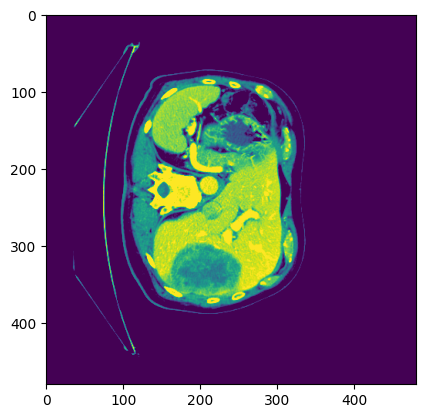

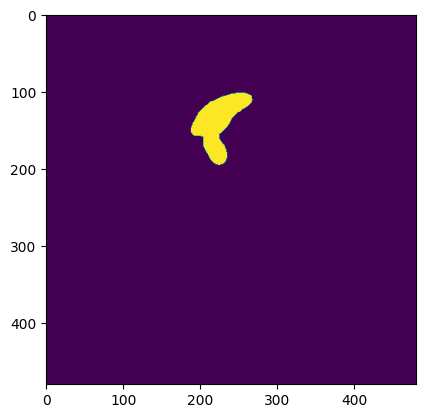

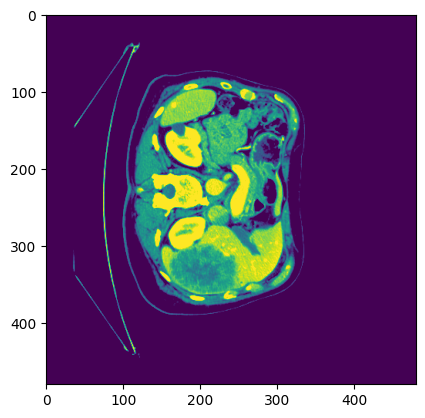

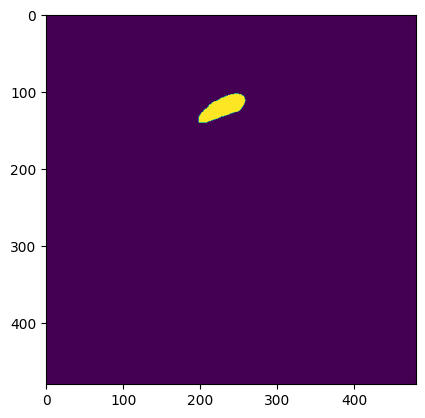

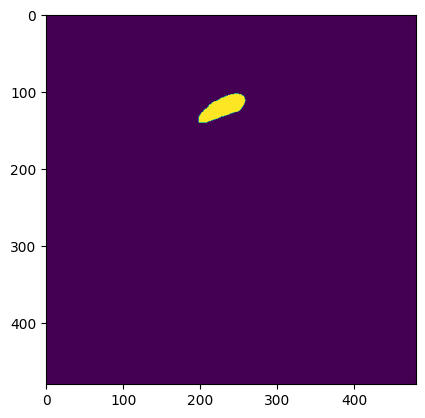

In [6]:
image,mask,imagee,maskk, aim, amas= test_gen.__getitem__(0)

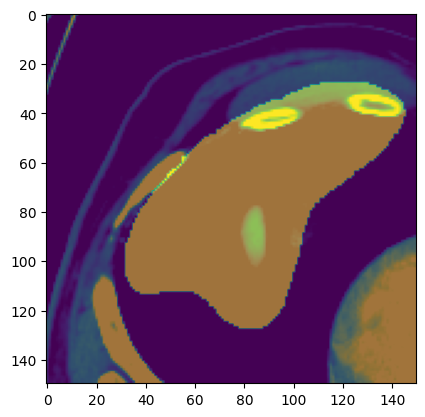

In [111]:
plt.imshow(imagee[50:200,100:250,210])
plt.imshow(maskk[50:200,100:250,210],alpha=0.5)

In [109]:
np.argwhere(maskk>0)[:,2]

array([206, 207, 208, ..., 226, 227, 228])

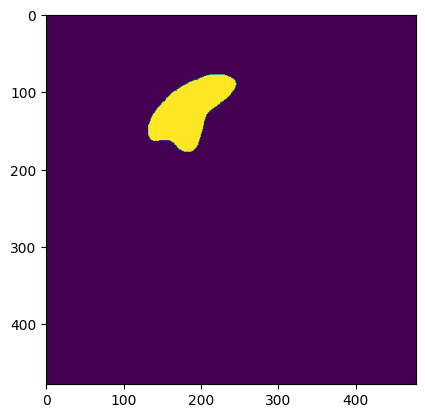

In [110]:
plt.imshow(maskk[:,:,210])

In [6]:
t,p = train_gen.__getitem__(1)


2023-07-24 11:53:00.030387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [8]:
t.shape

(4, 96, 96, 96, 1)

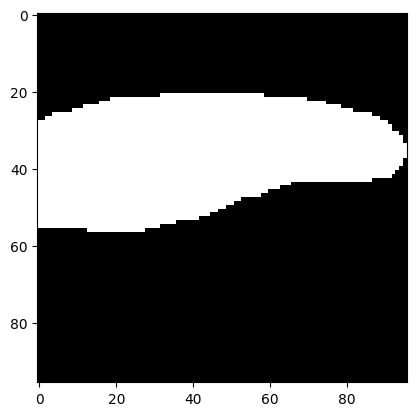

In [9]:
plt.imshow(p[2,:,:,45,0],'gray')

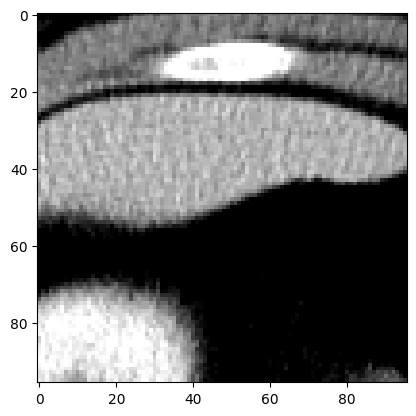

In [10]:
plt.imshow(t[2,:,:,45,0],'gray')

In [27]:
pp.shape

(435, 435, 270)

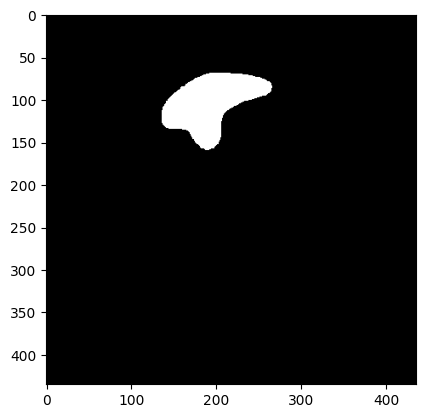

In [28]:
plt.imshow(pp[:,:,160],'gray')

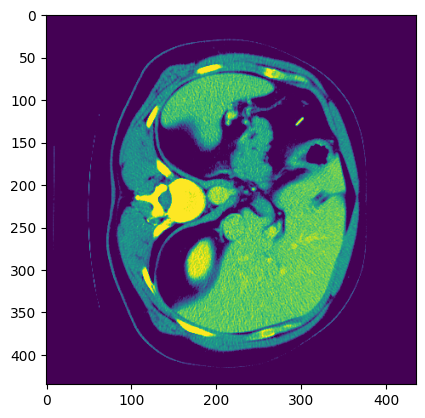

In [29]:
plt.imshow(tt[:,:,160])

In [65]:
np.unique(np.argwhere(p>0)[:,0])

array([19, 22, 23, 37, 38])

In [10]:
np.unique(p)

array([0, 1], dtype=uint8)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Input, MaxPooling3D, Dropout, concatenate, UpSampling3D, BatchNormalization
import tensorflow as tf

def Unet3D(inputs,num_classes,f=16, pretrained_weights = None):
    x =  Input(inputs)
    conv1 = Conv3D(f, 3, activation = 'relu', padding = 'same',data_format="channels_last")(x)
    conv1= BatchNormalization()(conv1)
    conv1 = Conv3D(f, 3, activation = 'relu', padding = 'same')(conv1)
    conv1= BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(f*2, 3, activation = 'relu', padding = 'same')(pool1)
    conv2= BatchNormalization()(conv2)
    conv2 = Conv3D(f*2, 3, activation = 'relu', padding = 'same')(conv2)
    conv2= BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(f*3, 3, activation = 'relu', padding = 'same')(pool2)
    conv3= BatchNormalization()(conv3)
    conv3 = Conv3D(f*3, 3, activation = 'relu', padding = 'same')(conv3)
    conv3= BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv4 = Conv3D(f*4, 3, activation = 'relu', padding = 'same')(pool3)
    conv4= BatchNormalization()(conv4)
    conv4 = Conv3D(f*4, 3, activation = 'relu', padding = 'same')(conv4)
    conv4= BatchNormalization()(conv4)
    drop4 = Dropout(0.01)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    conv5 = Conv3D(f*5, 3, activation = 'relu', padding = 'same')(pool4)
    conv5= BatchNormalization()(conv5)
    conv5 = Conv3D(f*5, 3, activation = 'relu', padding = 'same')(conv5)
    conv5= BatchNormalization()(conv5)
    drop5 = Dropout(0.01)(conv5)

    up6 = Conv3D(f*4, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(drop5))
    up6= BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=-1)
    conv6 = Conv3D(f*4, 3, activation = 'relu', padding = 'same')(merge6)
    conv6= BatchNormalization()(conv6)
    conv6 = Conv3D(f*4, 3, activation = 'relu', padding = 'same')(conv6)
    conv6= BatchNormalization()(conv6)

    up7 = Conv3D(f*3, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv6))
    up7= BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=-1)
    conv7 = Conv3D(f*3, 3, activation = 'relu', padding = 'same')(merge7)
    conv7= BatchNormalization()(conv7)
    conv7 = Conv3D(f*3, 3, activation = 'relu', padding = 'same')(conv7)
    conv7= BatchNormalization()(conv7)

    up8 = Conv3D(f*2, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv7))
    up8= BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=-1)
    conv8 = Conv3D(f*2, 3, activation = 'relu', padding = 'same')(merge8)
    conv8= BatchNormalization()(conv8)
    conv8 = Conv3D(f*2, 3, activation = 'relu', padding = 'same')(conv8)
    conv8= BatchNormalization()(conv8)

    up9 = Conv3D(f, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv8))
    up9= BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=-1)
    conv9 = Conv3D(f, 3, activation = 'relu', padding = 'same')(merge9)
    conv9= BatchNormalization()(conv9)
    conv9 = Conv3D(f, 3, activation = 'relu', padding = 'same')(conv9)
    conv9= BatchNormalization()(conv9)
#     conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs=x, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics = [dice_coef])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    print(model.summary())
    return model

In [6]:
a= Unet3D((96,96,96,1),1,f=16)

2023-08-24 17:10:33.263116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 96, 96, 96,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 96,   64         ['conv3d[0][0]']                 
 alization)                     16)                                                           

 conv3d_10 (Conv3D)             (None, 12, 12, 12,   41024       ['up_sampling3d[0][0]']          
                                64)                                                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 12, 12, 12,   256        ['conv3d_10[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 12, 12, 12,   0           ['dropout[0][0]',                
                                128)                              'batch_normalization_10[0][0]'] 
                                                                                                  
 conv3d_11 (Conv3D)             (None, 12, 12, 12,   221248      ['concatenate[0][0]']            
          

                                                                                                  
 batch_normalization_20 (BatchN  (None, 96, 96, 96,   64         ['conv3d_20[0][0]']              
 ormalization)                  16)                                                               
                                                                                                  
 conv3d_21 (Conv3D)             (None, 96, 96, 96,   6928        ['batch_normalization_20[0][0]'] 
                                16)                                                               
                                                                                                  
 batch_normalization_21 (BatchN  (None, 96, 96, 96,   64         ['conv3d_21[0][0]']              
 ormalization)                  16)                                                               
                                                                                                  
 conv3d_22

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

filepath = r"/home/rabeea/logs/unet_spleen/5layers_16_256_e4_350_gpu1.h5"
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stopping]

In [9]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-07-27 15:10:54.800572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


28/28 [==============================] - 456s 16s/step - loss: 0.5824 - dice_coef: 0.4176 - val_loss: 0.7054 - val_dice_coef: 0.2946
Epoch 2/350
28/28 [==============================] - 448s 16s/step - loss: 0.4400 - dice_coef: 0.5600 - val_loss: 0.6798 - val_dice_coef: 0.3202
Epoch 3/350
28/28 [==============================] - 445s 16s/step - loss: 0.4196 - dice_coef: 0.5804 - val_loss: 0.6667 - val_dice_coef: 0.3333
Epoch 4/350
28/28 [==============================] - 447s 16s/step - loss: 0.3267 - dice_coef: 0.6733 - val_loss: 0.6624 - val_dice_coef: 0.3376
Epoch 5/350
28/28 [==============================] - 445s 16s/step - loss: 0.2871 - dice_coef: 0.7129 - val_loss: 0.7588 - val_dice_coef: 0.2412
Epoch 6/350
28/28 [==============================] - 445s 16s/step - loss: 0.2708 - dice_coef: 0.7292 - val_loss: 0.7664 - val_dice_coef: 0.2336
Epoch 7/350
28/28 [==============================] - 448s 16s/step - loss: 0.2577 - dice_coef: 0.7423 - val_loss: 0.7944 - val_dice_coef: 0.20

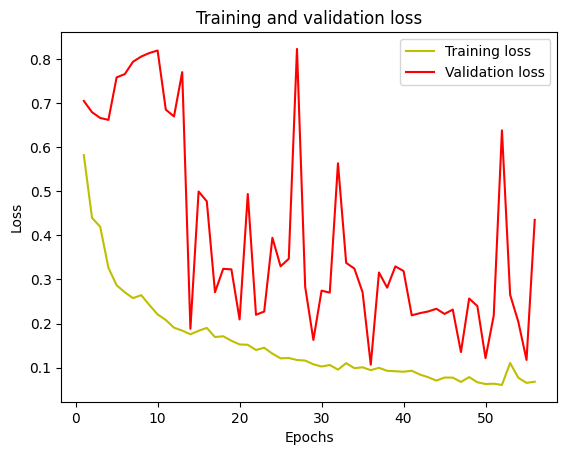

In [11]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

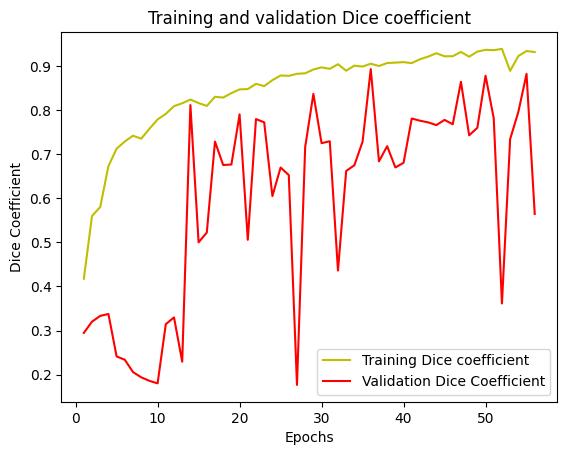

In [12]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [13]:
print('max training dice: ',max(acc))
print('max validation dice: ',max(val_acc))

max training dice:  0.9393731951713562
max validation dice:  0.8935478925704956


In [14]:
a.load_weights(filepath)

In [16]:
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for i in tqdm(range(0,len(testpath))):
    test_mask, pred_mask = inf(testpath[i],testpath_m[i],a)
    y_pred_argmax=np.where(pred_mask>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, test_mask))
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_2827599/172801869.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_2827599/172801869.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|█████████████████

at 0.9: dice:  0.6822325302161657
at 0.8: dice:  0.6832785780540099
at 0.7: dice:  0.6839477883681575
at 0.6: dice:  0.6840501799364355
at 0.5: dice:  0.6839637190913739
at 0.4: dice:  0.6828015177410046
at 0.3: dice:  0.6729099038649984
at 0.2: dice:  0.6017603163008051
at 0.1: dice:  0.4322359379326846
at 0.05: dice:  0.013254014359222199
at 0.01: dice:  0.012601841980172104


In [9]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-07-25 09:19:36.015476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


28/28 [==============================] - 466s 16s/step - loss: 0.6306 - dice_coef: 0.3694 - val_loss: 0.6960 - val_dice_coef: 0.3040
Epoch 2/350
28/28 [==============================] - 451s 16s/step - loss: 0.4627 - dice_coef: 0.5373 - val_loss: 0.6852 - val_dice_coef: 0.3148
Epoch 3/350
28/28 [==============================] - 447s 16s/step - loss: 0.3744 - dice_coef: 0.6256 - val_loss: 0.6305 - val_dice_coef: 0.3695
Epoch 4/350
28/28 [==============================] - 446s 16s/step - loss: 0.3237 - dice_coef: 0.6763 - val_loss: 0.7182 - val_dice_coef: 0.2818
Epoch 5/350
28/28 [==============================] - 447s 16s/step - loss: 0.3091 - dice_coef: 0.6909 - val_loss: 0.7388 - val_dice_coef: 0.2612
Epoch 6/350
28/28 [==============================] - 449s 16s/step - loss: 0.2848 - dice_coef: 0.7152 - val_loss: 0.7522 - val_dice_coef: 0.2478
Epoch 7/350
28/28 [==============================] - 447s 16s/step - loss: 0.2796 - dice_coef: 0.7204 - val_loss: 0.7771 - val_dice_coef: 0.22

In [12]:
print('max training dice: ',max(acc))
print('max validation dice: ',max(val_acc))

max training dice:  0.9485662579536438
max validation dice:  0.9532299041748047


In [14]:
a.load_weights(filepath)

In [15]:
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for i in tqdm(range(0,len(testpath))):
    test_mask, pred_mask = inf(testpath[i],testpath_m[i],a)
    y_pred_argmax=np.where(pred_mask>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, test_mask))
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_2409152/172801869.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_2409152/172801869.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|█████████████████

at 0.9: dice:  0.7476845162505186
at 0.8: dice:  0.7499026285213195
at 0.7: dice:  0.7511074275557956
at 0.6: dice:  0.7517733625572987
at 0.5: dice:  0.7524967111462814
at 0.4: dice:  0.7525384319284516
at 0.3: dice:  0.7352709804897501
at 0.2: dice:  0.635989994143596
at 0.1: dice:  0.322215647549271
at 0.05: dice:  0.05351063277693685
at 0.01: dice:  0.012599597545896936
